### The project as described on Kaggle

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.


### Data Fields
Field 0 contained the timestamp, fields 1 ... 8 were used for training. Field 11 for labeling/prediction. 

0 - datetime - hourly date + timestamp  

1 - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

2 - holiday - whether the day is considered a holiday 

3 - workingday - whether the day is neither a weekend nor holiday 

4 - weather - 1 = Clear, Few clouds, Partly cloudy, Partly cloudy, 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

5 - temp - temperature in Celsius

6 - atemp - "feels like" temperature in Celsius

7 - humidity - relative humidity

8 - windspeed - wind speed

9 - casual - number of non-registered user rentals initiated

10 - registered - number of registered user rentals initiated

11 - count - number of total rentals

### General ideas

For this project I implemented a very simple version of a self-organizing map. It is an unsupervised learning method consisting of a 2D (here square) map of nodes which classify similar input vectors. Also, close nodes ('neighborhood') should represent close input vectors.

An unsupervised algorithm doesn't provide predictions of actual outputs from the start. I addressed the need of a predicted output by labeling a node with the average of all its members (which resembles k-nearest neighbors.) A different approach could be to train a supervised method on all members of a given node.

### File structure
Files accessed by this notebook are under test, e.g., test/test.csv . Files accessed by the training notebook are under train/ . Some files are duplicated for clarity. Files like 'nodes.csv' which are shared by both notebooks are in the main directory . .

### Implementation comments

The training data was normalized (large values in the input data would dominate the distance function between nodes and inputs and skew the training) and shuffled (to avoid getting stuck in local minima.)

The self-organizing map gets initialized by providing the (square) number of nodes and the training data. Each node gets initialized with a different input vector from the training data.

Training one input vector consists of finding the node with the smallest Euclidean distance from the input vector and updating the node and its surrounding nodes (neighborhood) by the difference between the node and the input mulitplied by the learning rate. Neighborhoods are squares and each node is updated in this implementation with the same weight. One training cycle consists of training each input once. The total number of training cycles can be chosen freely. Over the course of the training the learning rate and size of the neighborhood get reduced in a linear fashion (other functions are possible, e.g., exp(-x).) This will stabilize the model toward the end of the training.

After the full training each node gets labeled with the average of its known training outputs. These labels are employed to predict the outputs for the test data.

Populating the interactive namespace from numpy and matplotlib
[   4.            1.            1.            4.           41.
   45.45500183  100.           56.99689865]
[ 1.          0.          0.          1.          0.81999999  0.75999999
  0.          0.        ]
labeling April data: 
labeling 10am data: 
labeling 6pm data: 
labeling all data: 
node labels: 


`%matplotlib` prevents importing * from pylab and numpy


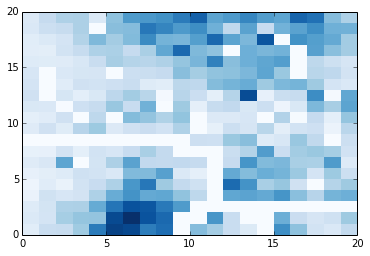

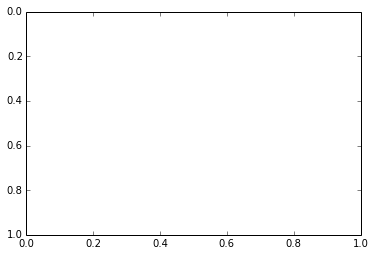

In [2]:
from numpy import genfromtxt, savetxt, maximum, minimum
from numpy.linalg import norm
import random, math, pickle
import matplotlib.pyplot
import numpy.random

# configure matplotlib to show figures embedded in the notebook
%pylab inline

#self-organizing map, assumed to be square, initialized with normalized data
class SOM :
    #initializes the nodes with normalized data, not random weights
    def __init__(self, nr_nodes, data) :
        #save length of one side of the map
        self.one_side = int(math.sqrt(nr_nodes) + 0.5)
        if self.one_side**2 != nr_nodes:
            raise ValueError('nr_nodes was not a perfect square')
        self.nodes = data[0::len(data)/nr_nodes][:nr_nodes]
            
    #save nodes to file
    def save_nodes(self, location) :
        pickle.dump(self.nodes, open(location, 'w'))
    
    #load nodes from file
    def load_nodes(self, location) :
        self.nodes = pickle.load(open(location, 'r'))
                    
    
    #returns the node with the closest Euclidian distance to a given input vector
    def find_winning_node(self, vector):
        min_value = norm(vector-self.nodes[0])
        min_count = 0
        for count in range(len(self.nodes)) :
            if(norm(vector-self.nodes[count]) < min_value) :
                min_value = norm(vector-self.nodes[count])
                min_count = count
        return min_count
    
    #update the neighborhood around the winning node
    #here we use a square neighborhood with the same weight to all updates inside
    def update_neighborhood(self, vector, winner, distance, learning_rate):
        #determine neighborhood - avoid leaving the map (don't go over borders)
        x = winner/self.one_side
        y = winner%self.one_side
        left = max(0,y-distance)
        right = min(self.one_side,y+distance+1)
        top = max(0,x-distance)
        bottom = min(self.one_side,x+distance+1)
        #update neighborhood
        for i in range(left,right):
            for j in range(top,bottom):
                k = self.one_side*j+i
                self.nodes[k] += learning_rate * (vector - self.nodes[k])

    #train each vector once
    def train_one_cycle(self, data, distance, learning_rate):
        node_count = [0]*len(self.nodes)
        for data_point in data :
            winner = self.find_winning_node(data_point)
            node_count[winner] += 1
            self.update_neighborhood(data_point, winner, distance, learning_rate)
        #show distribution of training vectors over nodes as a heatmap
        data = node_count
        heatmap = matplotlib.pyplot.pcolor(numpy.reshape( data, (self.one_side, self.one_side)), cmap=plt.cm.Blues)
        matplotlib.pyplot.show()
        matplotlib.pyplot.gca().invert_yaxis()

    #full training
    def train(self, data, nr_steps, distance, learning_rate):
        for i in range(0, nr_steps):
            #update distance and learning rate as necessary
            current_distance = distance - distance * i / nr_steps
            current_learning_rate = learning_rate - learning_rate * i / nr_steps
            print("step: {} distance: {} learning rate: {}".format(i, current_distance, current_learning_rate))
            self.train_one_cycle(data, current_distance, current_learning_rate)
            
    #labeling - make sure to use normalized data
    def label(self, data_with_labels):
        #determine average over all outputs in a given node
        node_label = [0.0]*len(self.nodes)
        node_label_count = [0]*len(self.nodes)
        #store average in node_prediction
        self.node_prediction = [0.0]*len(self.nodes)
        for data_point in data_with_labels:
            winner = self.find_winning_node(data_point[1:9])
            node_label[winner] += data_point[11]
            node_label_count[winner] += 1
        for j in range(len(self.nodes)):
            if(node_label_count[j] > 0):
                self.node_prediction[j] = node_label[j] / node_label_count[j]
        print("node labels: ")
        data = self.node_prediction
        heatmap = matplotlib.pyplot.pcolor(numpy.reshape( data, (self.one_side, self.one_side)), cmap=plt.cm.Blues)
        matplotlib.pyplot.show()
        matplotlib.pyplot.gca().invert_yaxis()
            
    #testing a single data point
    def test_datapoint(self, datapoint_without_labels):
        winner = self.find_winning_node(datapoint_without_labels[1:9])
        return [winner, datapoint_without_labels[0], self.node_prediction[winner]]
    
    #testing data set
    def test(self, data_without_labels):
        return [self.test_datapoint(datapoint) for datapoint in data_without_labels]
    
    #predicting a single data point
    def predict_datapoint(self, datapoint_without_labels):
        #the predicted value is the label of the node closest to the input
        return self.node_prediction[self.find_winning_node(datapoint_without_labels)]

    #predicting data set
    def predict(self, data_without_labels):
        return [[tuple(datapoint)[0], self.predict_datapoint(tuple(datapoint)[1:9])] for datapoint in data_without_labels]
            
#create the training & test sets, skipping the header row with [1:]
train_dataset = genfromtxt(open('test/train.csv','r'), delimiter=',', dtype='f12')[1:]
train = [x[1:9] for x in train_dataset]

test_dataset = genfromtxt(open('test/test.csv','r'), delimiter=',', dtype='f12')[1:]
test = [x[1:9] for x in test_dataset]

train_april_dataset = genfromtxt(open('test/train_april.csv','r'), delimiter=',', dtype='f12')
train_10am_dataset = genfromtxt(open('test/train_10am.csv','r'), delimiter=',', dtype='f12')
train_6pm_dataset = genfromtxt(open('test/train_6pm.csv','r'), delimiter=',', dtype='f12')

#shuffle the training data set to avoid getting stuck in local minima
random.shuffle(train)

#determine min and max for all training inputs
max_inputs = train[0]
min_inputs = train[0]

for x in train :
    max_inputs = maximum( max_inputs, x)
    min_inputs = minimum( min_inputs, x)
    
print(max_inputs)
print(min_inputs)

#normalize data, assumes non-negativity
train /= max_inputs
for data_point in train_dataset:
    data_point[1:9] /= max_inputs
for data_point in test_dataset:
    data_point[1:9] /= max_inputs
for data_point in train_april_dataset:
    data_point[1:9] /= max_inputs
for data_point in train_10am_dataset:
    data_point[1:9] /= max_inputs
for data_point in train_6pm_dataset:
    data_point[1:9] /= max_inputs

#create the SOM - training data is employed for initializing nodes
som = SOM(400, train)

#either train the SOM or load the pretrained weights - check size
som.load_nodes('nodes.csv')
#som.train(train, 100, 6, 0.2)

#test categorization power of the SOM by checking distribution of all April data points
print("labeling April data: ")
#som.label(train_april_dataset)

#test categorization power of the SOM by checking distribution of all 10am data points
print("labeling 10am data: ")
#som.label(train_10am_dataset)

#test categorization power of the SOM by checking distribution of all 6pm data points
print("labeling 6pm data: ")
#som.label(train_6pm_dataset)

#label nodes with all data points for prediction
print("labeling all data: ")
som.label(train_dataset)

prediction_dataset = genfromtxt(open('test.csv','r'), delimiter=',', dtype='S20,f,f,f,f,f,f,f,f')[1:]

#predict on test data for submission
predicted = som.predict(prediction_dataset)

#save the predictions to the file
savetxt('submission.csv', numpy.array(predicted), delimiter=',', fmt ="%s", header='datetime,count', comments = '')



### Labeling
The labeling is reproduced here. Technically, only the labeling with all data is necessary for testing. There must be a bug in my code since the first plot doesn't have the inverted y-axis but an inverted empty plot is drawn at the end of the last cell.

#### Quick testing note WITHOUT prediction
The labeling is the only 'time expensive' step in this notebook (assuming loading of the weights.) Therefore, for 'quick' testing WITHOUT prediction it will be faster to use train_april_dataset for labeling because it only contains 1/12 of the data. But this will leave the predicted bike rentals at 0.0 for all nodes without April data (see heatmap.)

### Testing
Wrote an 'additional' predict function because the test function didn't correctly handle the timestamps (I preprocessed the input file with vi.) Now this notebook reads data from 'test.csv', predicts the total number of bike rentals for each input vector, and writes timestamp and prediction to 'submission.csv'. To predict on another file 'test.csv' should be replaced with that file. The results will be in submission.csv.

### Results
As the 10am and 6pm heatmaps already suggested, there is no strong clustering of the training data by time of day for the suggested self-organizing map. This leads to a more or less random prediction by this self-organizing map. For actual prediction a time series analysis makes more sense. Which could be trained on a similar self-organizing map with sliding averages over the number of bike rentals as additional inputs.
